# Using SCRUMP

## Fast approximate matrix profiles with SCRIMP++ and `stumpy.scrump`

In 
[this paper](https://www.cs.ucr.edu/~eamonn/SCRIMP_ICDM_camera_ready_updated.pdf), a new approach to a incremental matrix profile calculation is presented: The SCRIMP++ algorithm. The algorithm uses certain properties of the matrix profile calculation, to hugely reduce the computation time if only an approximate matrix profile is needed. We will see in this tutorial, that for a lot of applications it can suffice to calculate the distance profiles of only a tiny subset of sub-sequences.

`stumpy` leverages some properties to provide a multi-threaded implementation using NUMBA, called `stumpy.scrump`, and allows for the matrix profile to be refined if the desired quality is not yet reached. Currently, only self-joins are supported.

## Getting started

First, let us import some packages we will use for data loading, analyzing, and plotting.

In [1]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt
import urllib
import ssl
import io
import os

The python function below is going to be used throughout this example to automatically resize and create the plots that are displayed using the Matplotlib python plotting package.

In [2]:
def change_plot_size(width, height, plt):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.rcParams["figure.figsize"] = fig_size
    plt.rcParams['xtick.direction'] = 'out'
    
change_plot_size(20, 6, plt)

## Load the Steamgen Dataset

This data was generated using fuzzy models applied to mimic a steam generator at the Abbott Power Plant in Champaign, IL. The data feature that we are interested in is the output steam flow telemetry that has units of kg/s and the data is "sampled" every three seconds with a total of 9,600 datapoints.


In [3]:
colnames = ['drum pressure',
            'excess oxygen',
            'water level',
            'steam flow'
           ]

context = ssl.SSLContext()  # Ignore SSL certificate verification for simplicity
url = 'https://www.cs.ucr.edu/~eamonn/iSAX/steamgen.dat'
raw_bytes = urllib.request.urlopen(url, context=context).read()
data = io.BytesIO(raw_bytes)
steam_df = pd.read_csv(data, header=None, sep="\s+")
steam_df.columns = colnames
steam_df.head()

,drum pressure,excess oxygen,water level,steam flow
0,320.08239,2.506774,0.032701,9.302970
1,321.71099,2.545908,0.284799,9.662621
2,320.91331,2.360562,0.203652,10.990955
3,325.00252,0.027054,0.326187,12.430107
4,326.65276,0.285649,0.753776,13.681666


## Visualizing the Steamgen Dataset

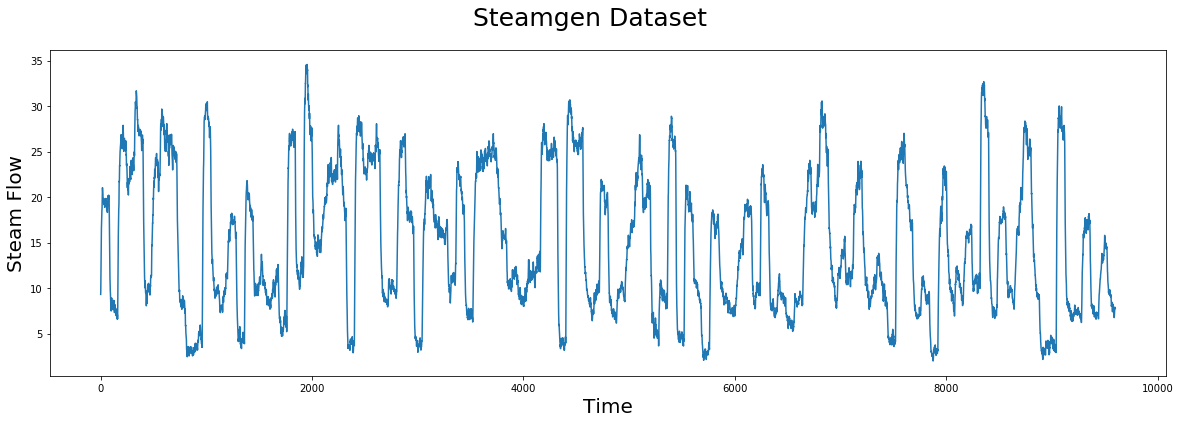

In [4]:
plt.suptitle('Steamgen Dataset', fontsize='25')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Steam Flow', fontsize='20')
plt.plot(steam_df['steam flow'].values)

## Computing the complete matrix profile

Now, as a benchmark, we will compute the full matrix profile of our data with a window wize of `m=640`. For this we use stumpys parralelized implementation of STOMP, `stumpy.stump`.

In [5]:
m = 640
mp = stumpy.stump(steam_df['steam flow'], m)

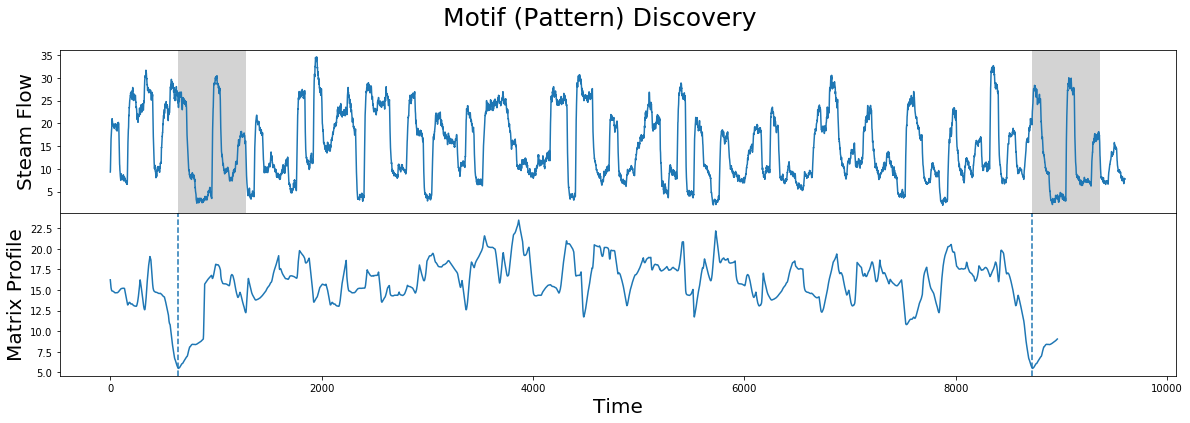

In [6]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='25')

axs[0].plot(steam_df['steam flow'].values)
axs[0].set_ylabel('Steam Flow', fontsize='20')
rect = Rectangle((643, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((8724, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=643, linestyle="dashed")
axs[1].axvline(x=8724, linestyle="dashed")
axs[1].plot(mp[:, 0])

The global minima of the matrix profile, symbolised with the dashed lines, are the indices of the top motif, i.e. the two sub-sequences which are most similar to each other. When using the matrix profile, in many application these are the two most important subsequences, and we will see how we can use SCRIMP++ to find them faster.

We will use the function below to visually compare the true matrix profile with its approximations.

In [7]:
def compare_approximation(mp, approximated_mp):
    fig, ax = plt.subplots(gridspec_kw={'hspace': 0})
    plt.suptitle('Comparison of approximated matrix profile', fontsize='25')

    ax.set_xlabel('Time', fontsize ='20')
    ax.axvline(x=643, linestyle="dashed")
    ax.axvline(x=8724, linestyle="dashed")
    ax.set_ylim((5, 28))
    ax.plot(approximated_mp[:, 0], color="firebrick", label="Approximation")
    ax.plot(mp[:, 0], label="True MP")
    ax.legend()

## Computing an approximation using SCRUMP

Now, let us see how to use `stumpy.scrump` to approximate the matrix profile. To calculate the full matrix profile, one has to compute the whole distance matrix, i.e. the distances between all pairs of subsequences. SCRIMP++ computes this distance matrix diagonal-wise, but only uses a subset of all diagonals. How many you want to use is controlled by the `percentage` parameter. The more diagonals you use, the better the approximation will be, but this also implies a higher computation time. Chosing a value of `1.0`, or 100%, of all subsequences, produces the exact matrix profile, but in theory this will be slightly slower than using STOMP directly (see the referenced paper). It is important to note, that since less pairwise distances are computed, but no actually computed pairwise distance is approximated, it is alway guaranteed that `Appriximation >= True_MP`.

In our example we chose to approximate the matrix profile using only 1% of all diagonals, and see what happens. Notice two things: First, we pass `pre_scrump=False`. Scrimp++ consist of a preprocessing step calles PRESCRIMP and the SCRIMP algorithm. For now, we chose to turn the preprocessing off. Second, `stumpy.scrump` returns a python generator. We will see why this is useful below. To get the first approximation, i.e. the matrix profile when using only 1% of all subsequences, we call the `next` function on out generator. Please have in mind that the approximations are done by randomly selecting diagonals, i.e. rerunning the generator creation will result in a different sequence of approximated matrix profiles.

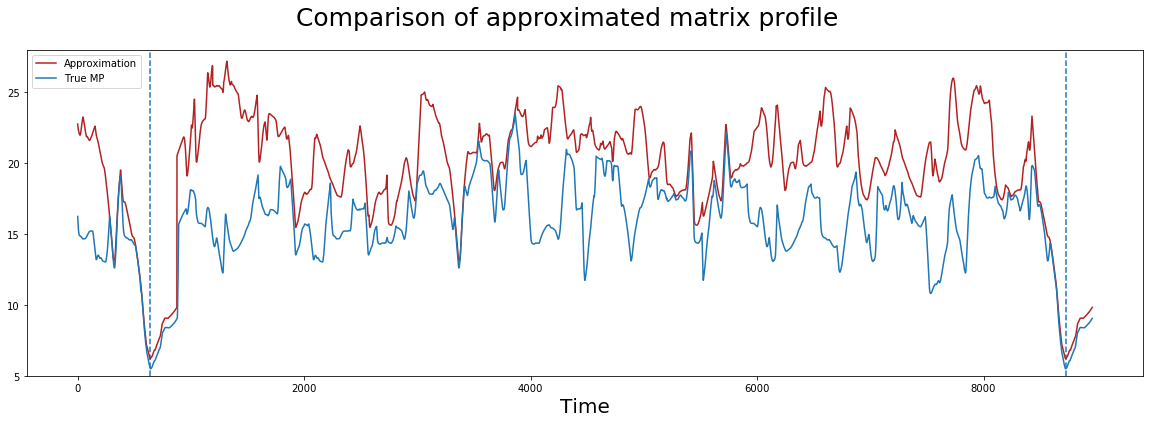

In [8]:
percentage = 0.01
scrump_generator = stumpy.scrump(steam_df['steam flow'], m, percentage=percentage, pre_scrump=False)
approximated_mp = next(scrump_generator)

compare_approximation(mp, approximated_mp)

We can see, that this approximation (in red) is far from perfect. There are some similarities between the two, but the lowest points in the approximation do not correspond to the true minima yet.

## Refining the distance profile

However, we can incrementally update and refine the approximation, by calling our generator again. Below, we call `next` nine more times, so our new approximated matrix profile will be the matrix profile after computing the matrix profile using 10% of all diagonals of the distance matrix.

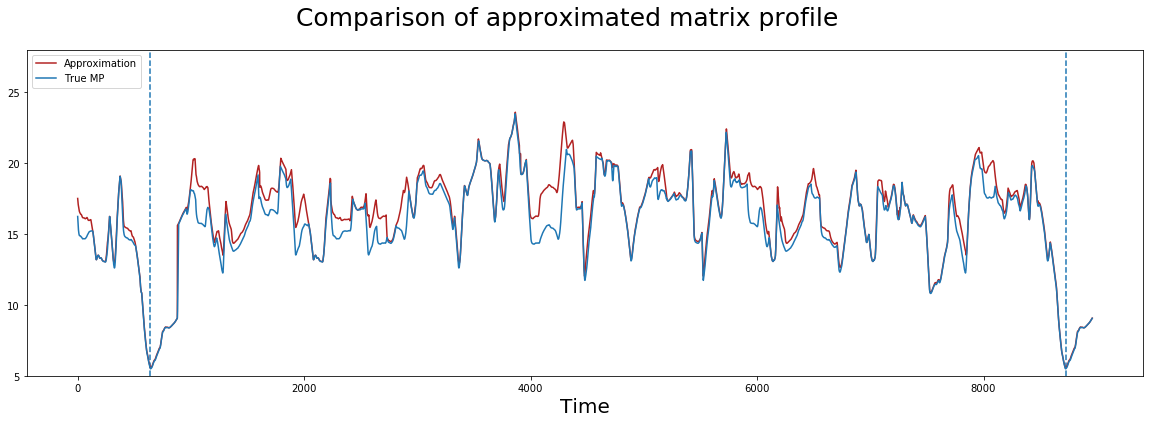

In [9]:
for _ in range(9):
    approximated_mp = next(scrump_generator)

compare_approximation(mp, approximated_mp)

Now, this result is much more convincing! We can see that the two profiles are very similar, in particular the important features like global minima are at almost equal, if not equal, positions. For most applications this is enough, as an offset of a few points usually does not matter, and the number of distances that had to be calculated was reduced by a factor of ten!

## The power of preprocessing

Until now, we only ran SCRIMP, not SCRIMP++, since we deactivated the preprocessing. PRESCRIMP is an algorithm that preprocesses the data with complexity `O(n log(n) / s)`, where `n` is the number of points and `s` is called the sampling rate. STOMP and SCRIMP both are of complexity `O(n^2)`, so in general preprocessing is 'cheap'. PRESCRIMP already computes the distances of some subsequence pairs and the sampling rate controls of how many. Typically, a good value is `s=m/4`, the same size as the exclusion zone, and this value is used if you pass `None` to the `scrimp.scrump` function call.

Below we will approximate the matrix profile again with 1% of all diagonals, but this time enable preprocessing. Obviously, this will take a bit longer to compute, since some more calculations have to be done.

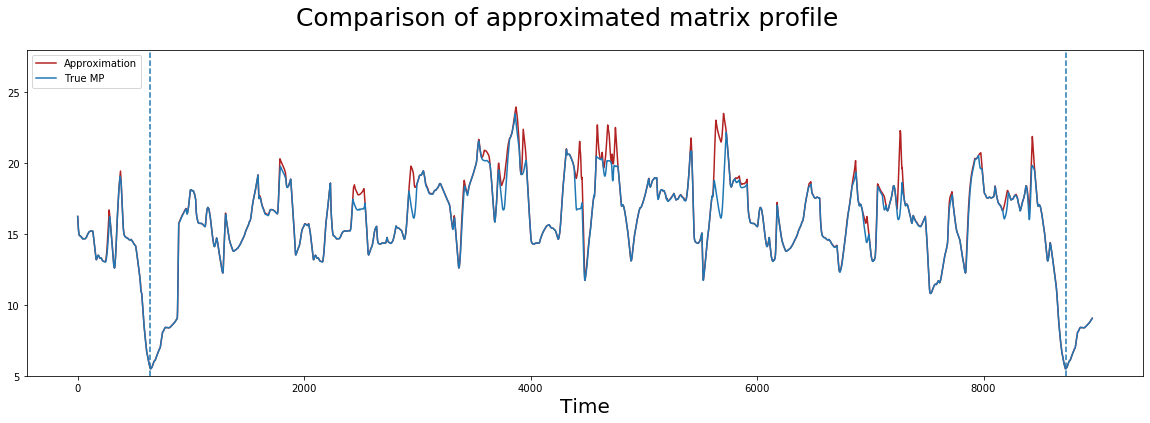

In [10]:
percentage = 0.01
scrump_generator = stumpy.scrump(steam_df['steam flow'], m, percentage=percentage, pre_scrump=True, s=None)
approximated_mp = next(scrump_generator)

compare_approximation(mp, approximated_mp)

However, one can see that in this example, using only one percent of all subsequences, the approximation and the true matrix profile are visually almost indistinguishable. With increasing time series length, the benefit of using preprocessing grows even further. Depending on the size of the data you want to analyze and the available computing time, it is worth to compute a higher percentage of distances to be sure that the approximation is good.

## Summary

That's it! You have learned how to approximate the matrix profile using `stumpy.scrump` and hopefully can use the approximated matrix profile in your application.

## Resources

[Matrix Profile XI: SCRIMP++: Time Series Motif Discovery at Interactive Speeds](https://www.cs.ucr.edu/~eamonn/SCRIMP_ICDM_camera_ready_updated.pdf)